In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# 加载数据

In [2]:
data = pd.read_csv('../../data/criteo_sampled_data.csv')
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [3]:
cols = data.columns.values

# 数据预处理

## 定义特征组

In [4]:
dense_feats = [f for f in cols if f[0] == "I"]
sparse_feats = [f for f in cols if f[0] == "C"]

## 处理dense特征

In [5]:
def process_dense_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna(0.0)
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    return d

In [6]:
data_dense = process_dense_feats(data, dense_feats)

## 处理sparse特征

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
def process_sparse_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d

In [9]:
data_sparse = process_sparse_feats(data, sparse_feats)

In [10]:
total_data = pd.concat([data_dense, data_sparse], axis=1)

In [11]:
total_data['label'] = data['label']

# xDeepFM

## 线性模型部分

### dense特征

In [12]:
import tensorflow as tf

In [13]:
dense_inputs = []
for f in dense_feats:
    _input = Input([1], name=f)
    dense_inputs.append(_input)

In [14]:
dense_inputs

[<tf.Tensor 'I1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I2:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I4:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I5:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I6:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I7:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I8:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I9:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I10:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I11:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I12:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I13:0' shape=(None, 1) dtype=float32>]

In [52]:
concat_dense_inputs = Concatenate(axis=1)(dense_inputs)
fst_order_dense_layer = Dense(1)(concat_dense_inputs)
fst_order_dense_layer

<tf.Tensor 'dense_5/BiasAdd:0' shape=(None, 1) dtype=float32>

### sparse特征

In [16]:
sparse_inputs = []
for f in sparse_feats:
    _input = Input([1], name=f)
    sparse_inputs.append(_input)

In [17]:
sparse_1d_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_feats[i]
    voc_size = data[f].nunique()
    _embed = Flatten()(Embedding(voc_size+1, 1, embeddings_regularizer=tf.keras.regularizers.l2(0.5))(_input))
    sparse_1d_embed.append(_embed)

In [18]:
fst_order_sparse_layer = Add()(sparse_1d_embed)

In [19]:
fst_order_sparse_layer

<tf.Tensor 'add/add_24:0' shape=(None, 1) dtype=float32>

### 合并linear部分

In [20]:
linear_part = Add()([fst_order_dense_layer, fst_order_sparse_layer])

## Compressed Interaction Network

In [21]:
k = 8

In [22]:
# 只考虑sparse的二阶交叉
sparse_kd_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_feats[i]
    voc_size = data[f].nunique()
    _embed = Embedding(voc_size+1, k, embeddings_regularizer=tf.keras.regularizers.l2(0.7))(_input)
    sparse_kd_embed.append(_embed)

In [23]:
sparse_kd_embed

[<tf.Tensor 'embedding_26/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_27/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_28/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_29/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_30/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_31/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_32/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_33/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_34/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_35/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_36/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtyp

In [53]:
# 构建feature mmap
input_feature_map = Concatenate(axis=1)(sparse_kd_embed)
input_feature_map

<tf.Tensor 'concatenate_9/concat:0' shape=(None, 26, 8) dtype=float32>

In [25]:
def compressed_interaction_net(x0, xl, k, n_filters):
    """
    @param x0: 原始输入
    @param xl: 第l层的输入
    @param k: embedding dim
    @param n_filters: 压缩网络filter的数量
    """
    # 这里设x0中共有m个特征，xl中共有h个特征
    
    # 1.将x0与xl按照k所在的维度（-1）进行拆分，每个都可以拆成k列
    x0_cols = tf.split(x0, k, axis=-1)  # ?, m, k
    xl_cols = tf.split(xl, k, axis=-1)  # ?, h, k
    
    assert len(x0_cols)==len(xl_cols), print("error shape!")
    
    # 2.遍历k列，对于x0与xl所在的第i列进行外积计算，存在feature_maps中
    feature_maps = []
    for i in range(k):
        feature_map = tf.matmul(xl_cols[i], x0_cols[i], transpose_b=True)  # 外积 ?, h, m
        feature_map = tf.expand_dims(feature_map, axis=-1)  # ?, h, m, 1
        feature_maps.append(feature_map)
    
    # 3.得到 h × m × k 的三维tensor
    feature_maps = Concatenate(axis=-1)(feature_maps)  # ?, h, m, k
    
    # 3.压缩网络
    x0_n_feats = x0.get_shape()[1]  # m
    xl_n_feats = xl.get_shape()[1]  # h
    reshaped_feature_maps = Reshape(target_shape=(x0_n_feats * xl_n_feats, k))(feature_maps)  # ?, h*m, k
    transposed_feature_maps = tf.transpose(reshaped_feature_maps, [0, 2, 1])  # ?, k, h*m
    
    new_feature_maps = Conv1D(n_filters, 1, 1)(transposed_feature_maps)  # ?, k, n_filters
    new_feature_maps = tf.transpose(new_feature_maps, [0, 2, 1])  # ?, n_filters, k
    
    return new_feature_maps

In [26]:
def build_cin(x0, k=8, n_layers=3, n_filters=12):
    """
    构建多层CIN网络
    @param x0: 原始输入的feature maps: ?, m, k
    @param k: 特征embedding的维度
    @param n_layers: CIN网络层数
    @param n_filters: 每层CIN网络输出的feature_maps的个数
    """
    # cin layers
    cin_layers = []
    # 存储每一层cin sum pooling的结果
    pooling_layers = []
    xl = x0
    for layer in range(n_layers):
        xl = compressed_interaction_net(x0, xl, k, n_filters)
        cin_layers.append(xl)
        # sum pooling
        pooling = Lambda(lambda x: K.sum(x, axis=-1))(xl)
        pooling_layers.append(pooling)
    
    # 将所有层的pooling结果concat起来
    output = Concatenate(axis=-1)(pooling_layers)
    
    return output

In [27]:
cin_layer = build_cin(input_feature_map)

In [28]:
cin_layer

<tf.Tensor 'concatenate_5/concat:0' shape=(None, 36) dtype=float32>

## DNN Part

In [29]:
embed_inputs = Flatten()(Concatenate(axis=-1)(sparse_kd_embed))

In [30]:
fc_layer = Dropout(0.5)(Dense(128, activation='relu')(embed_inputs))
fc_layer = Dropout(0.3)(Dense(128, activation='relu')(fc_layer))
fc_layer_output = Dropout(0.1)(Dense(128, activation='relu')(fc_layer))

In [31]:
fc_layer_output

<tf.Tensor 'dropout_2/cond/Identity:0' shape=(None, 128) dtype=float32>

## Output Layer

In [32]:
linear_part

<tf.Tensor 'add_1/add:0' shape=(None, 1) dtype=float32>

In [33]:
cin_layer

<tf.Tensor 'concatenate_5/concat:0' shape=(None, 36) dtype=float32>

In [34]:
fc_layer_output

<tf.Tensor 'dropout_2/cond/Identity:0' shape=(None, 128) dtype=float32>

In [35]:
concat_layer = Concatenate()([linear_part, cin_layer, fc_layer_output])

In [36]:
output_layer = Dense(1, activation='sigmoid')(concat_layer)

In [37]:
output_layer

<tf.Tensor 'dense_4/Sigmoid:0' shape=(None, 1) dtype=float32>

## 编译模型

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [39]:
model = Model(dense_inputs+sparse_inputs, output_layer)

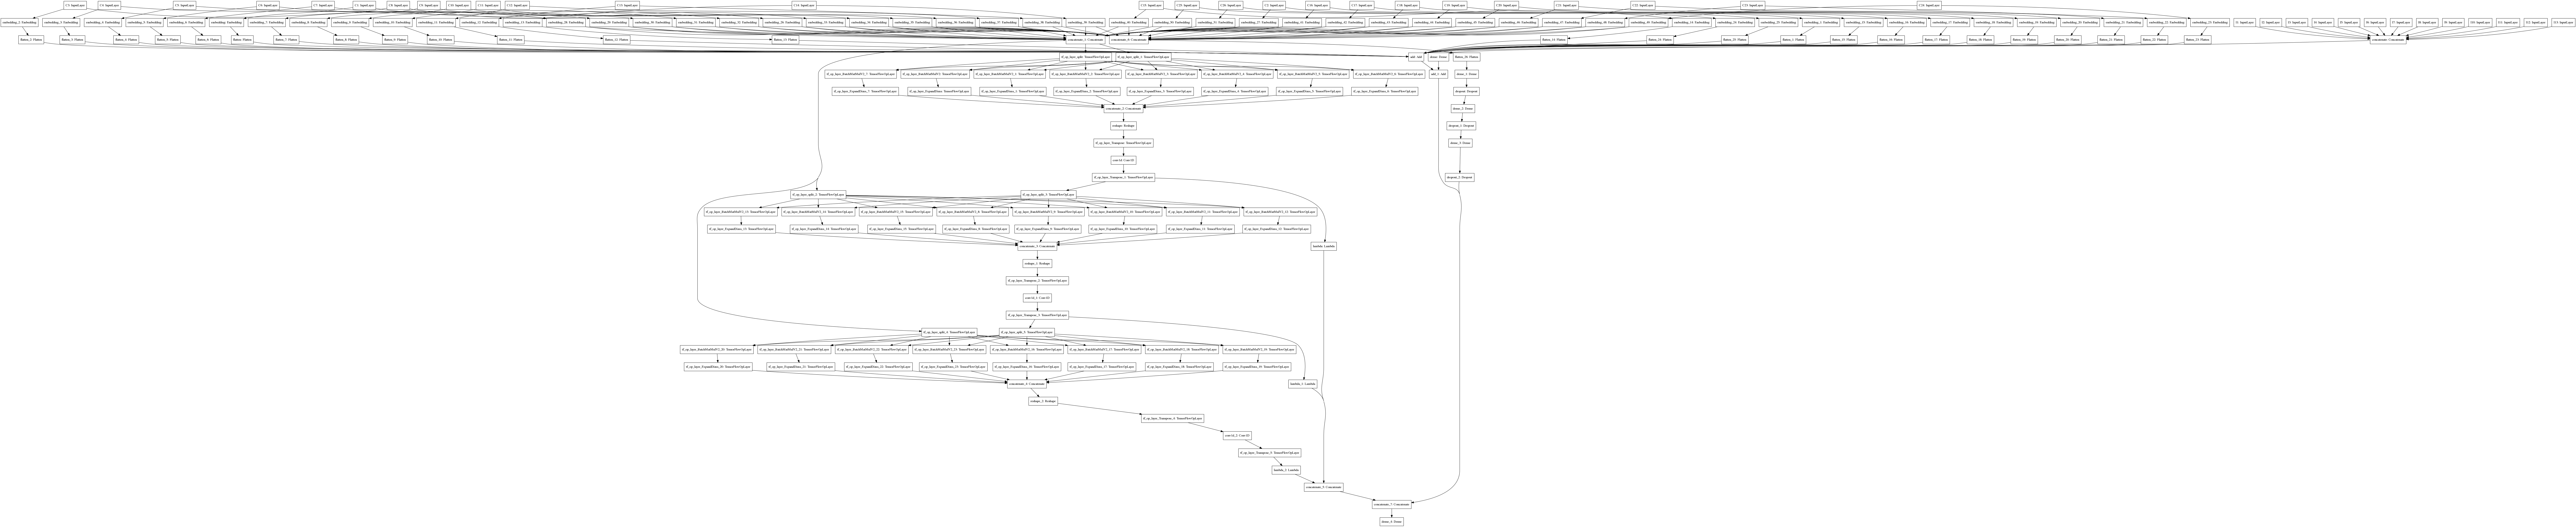

In [40]:
plot_model(model, "xdeepfm.png")

In [41]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C4 (InputLayer)                 [(None, 1)]          0                                            
_______________________________________________________________________________________

In [42]:
import tensorflow as tf

In [43]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

## 训练

In [44]:
from tensorflow.keras.callbacks import TensorBoard

In [45]:
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0, 
                 write_graph=True, 
                 write_grads=True, 
                 write_images=True,
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [46]:
train_data = total_data.loc[:500000-1]
valid_data = total_data.loc[500000:]

In [47]:
train_dense_x = [train_data[f].values for f in dense_feats]
train_sparse_x = [train_data[f].values for f in sparse_feats]

In [48]:
train_label = [train_data['label'].values]

In [49]:
val_dense_x = [valid_data[f].values for f in dense_feats]
val_sparse_x = [valid_data[f].values for f in sparse_feats]

In [50]:
val_label = [valid_data['label'].values]

In [51]:
model.fit(train_dense_x+train_sparse_x, 
          train_label, epochs=5, batch_size=256,
          validation_data=(val_dense_x+val_sparse_x, val_label), 
          callbacks=[tbCallBack])

Epoch 1/5


/home/work/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   1/1954 [..............................] - ETA: 0s - loss: 4501.6406 - binary_crossentropy: 0.9216 - auc: 0.4995WARNING:tensorflow:From /home/work/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1954/1954 [==============================] - 58s 30ms/step - loss: 32.7019 - binary_crossentropy: 0.5206 - auc: 0.6973 - val_loss: 0.5770 - val_binary_crossentropy: 0.5079 - val_auc: 0.7278
Epoch 2/5
1954/1954 [==============================] - 57s 29ms/step - loss: 0.5712 - binary_crossentropy: 0.4999 - auc: 0.7343 - val_loss: 0.5742 - val_binary_crossentropy: 0.5042 - val_auc: 0.7364
Epoch 3/5
1954/1954 [==============================] - 56s 29ms/step - loss: 0.5878 - binary_crossentropy: 0.4972 - auc: 0.7386 - val_loss: 0.6028 - val_binary_crossentropy: 0.5056 - val_auc: 0.7331
Epoch 4/5
